In [1]:
# Downloaded all the necessary libararies
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Loading the training and testing data from CSV files
train_df = pd.read_csv('./Data/train.csv')
test_df = pd.read_csv('./Data/test.csv')

# Filling missing values in 'keyword' and 'location' columns with empty strings
train_df['keyword'].fillna('', inplace=True)
train_df['location'].fillna('', inplace=True)
test_df['keyword'].fillna('', inplace=True)
test_df['location'].fillna('', inplace=True)

# Combining 'keyword', 'location', and 'text' columns into a single text column for processing
train_df['combined_text'] = train_df['keyword'] + " " + train_df['location'] + " " + train_df['text']
test_df['combined_text'] = test_df['keyword'] + " " + test_df['location'] + " " + test_df['text']

# Preprocessing the combined text by converting to lowercase and removing special characters
train_df['combined_text'] = train_df['combined_text'].str.lower().str.replace('[^a-z0-9\s]', '', regex=True)
test_df['combined_text'] = test_df['combined_text'].str.lower().str.replace('[^a-z0-9\s]', '', regex=True)

# Splitting the training data into a training set and a validation set for model evaluation
train_text, val_text, train_labels, val_labels = train_test_split(
    train_df['combined_text'], train_df['target'], test_size=0.1
)

# Initializing the tokenizer from the DistilBERT model, which is a lighter version of BERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenizing the training and validation text
# This will convert text to a format that the model can understand
train_encodings = tokenizer(train_text.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_text.tolist(), truncation=True, padding=True, max_length=128)

# Defining a custom dataset class to handle the PyTorch data loading
class DisasterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Creating dataset objects for training and validation
train_dataset = DisasterDataset(train_encodings, train_labels.tolist())
val_dataset = DisasterDataset(val_encodings, val_labels.tolist())

# Initializing the DistilBERT model for sequence classification with two labels
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)



2024-02-07 00:11:39.039703: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 00:11:39.039793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 00:11:39.205799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_34/3578005809.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# Defining a function to compute evaluation metrics (F1 score and accuracy)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

# Setting up training arguments, including directory for results, number of epochs, batch size, etc.
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    report_to="none"
)

# Initializing the Trainer with the model, training arguments, datasets, and evaluation metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Training the model on the dataset

# Also downloaded transformers 
# pip install torch

In [3]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.452500,0.368801,0.842520,0.823529
2,0.426900,0.365890,0.839895,0.805732
3,0.316700,0.365645,0.849081,0.822257


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=645, training_loss=0.4146027949429298, metrics={'train_runtime': 98.6336, 'train_samples_per_second': 208.377, 'train_steps_per_second': 6.539, 'total_flos': 324372556873404.0, 'train_loss': 0.4146027949429298, 'epoch': 3.0})

In [4]:
trainer.save_model('distilbert.model')

In [5]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [6]:
val_encodings = tokenizer(val_text.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
input_ids = val_encodings.get('input_ids')
attention_mask = val_encodings.get('attention_mask')

In [7]:
with torch.no_grad():
    outputs = model(input_ids.to('cuda'), attention_mask=attention_mask.to('cuda'))
    val_pred = outputs.logits.cpu().argmax(axis=-1)
    val_probas = tf.nn.softmax(outputs.logits.cpu())

In [8]:
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       421
           1       0.87      0.78      0.82       341

    accuracy                           0.85       762
   macro avg       0.85      0.84      0.85       762
weighted avg       0.85      0.85      0.85       762



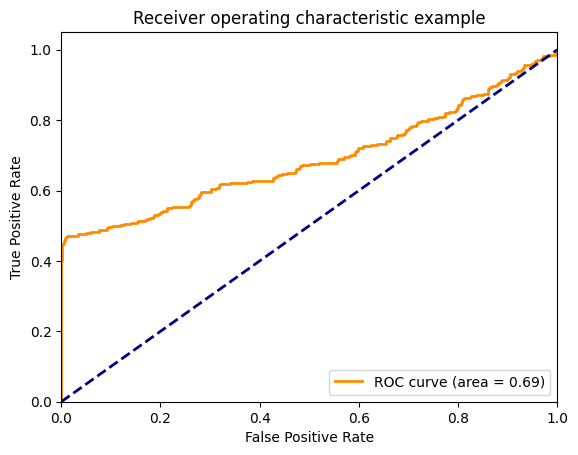

In [10]:
fpr, tpr, thresholds = roc_curve(val_labels, val_probas.numpy().max(axis=1))
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

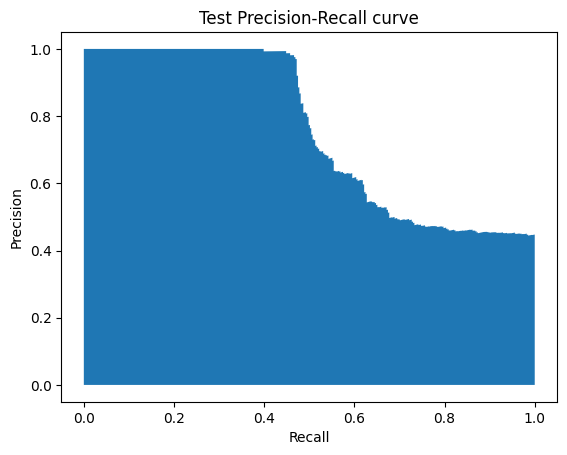

In [11]:
precision, recall, thresholds = precision_recall_curve(val_labels, val_probas.numpy().max(axis=1))
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve");
plt.savefig("pr_curve.png")

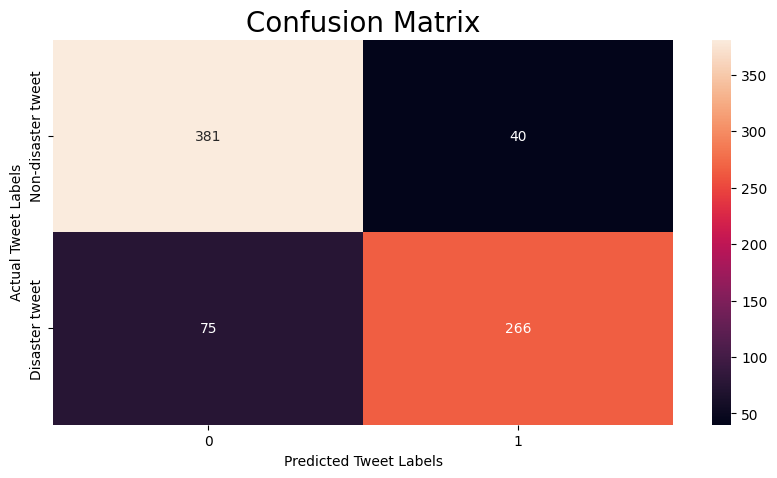

In [13]:
# Generate the confusion matrix that shows the true positive, true neative, false positive, and false negative labels
matrix = confusion_matrix(val_labels, val_pred)
labels= ["Non-disaster tweet", "Disaster tweet"]
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(matrix, annot=True, fmt="g", ax=ax)
plt.xlabel("Predicted Tweet Labels")
plt.ylabel("Actual Tweet Labels")
plt.title("Confusion Matrix", size=20)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.savefig('confusion_matrix.png')
plt.show()

Inference on test dataset

In [14]:
test_encodings = tokenizer(test_df['combined_text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')

In [15]:
input_ids = test_encodings.get('input_ids')
attention_mask = test_encodings.get('attention_mask')

In [ ]:
with torch.no_grad():
    outputs = model(input_ids.to('cuda'), attention_mask=attention_mask.to('cuda'))
    Y_pred = outputs.logits.cpu().argmax(axis=-1)
    submission_df = pd.read_csv("./Data/sample_submission.csv")
    submission = pd.DataFrame({"id": submission_df['id'],
            "target":Y_pred})
    submission.to_csv('submission.csv', index=False)

The submission for this run resulted in F1-score of 0.8201 on kaggle competition.